## Averaged flows


In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
import os
import sys
sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder
%matplotlib qt

def divergence_npgrad(flow):
    # flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dx = np.gradient(Fx, axis=0)
    dFy_dy = np.gradient(Fy, axis=1)
    return dFx_dx + dFy_dy


def analyze_defects(img):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, 25)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf



# Defect dynamics time lapse

## Make dataframe with all defects and save as csv

In [ ]:
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])

PLOT = True

# image_list = glob.glob(r"C:/Users/victo/Downloads/SB_lab/RPE1_C2C12_/Test001/*.tif")
image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*s14*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[50:200:1]

if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_axis_off()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

    # u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
    # v = np.zeros_like(u)


for im1, im2 in zip(image_list[:-1], image_list[1:]):
    print(os.path.basename(im1))
    img1 = cv2.imread(im1)[:,:,0]
    
    # calculate velocity and plot fields
    if PLOT:
        ax.clear()
        img2 = cv2.imread(im2)[:,:,0]
        flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
            winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)  
        # >> uncomment to have average flow representation
        # >>  TO DO devide by number of frames
        # u += flow[..., 0]
        # v += flow[..., 1]
        # flow = np.stack((u, v), axis=-1)

        divergence = gaussian_filter(divergence_npgrad(flow), sigma=30)

        # Apply Contrast Limited Adaptive Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(255-img_clahe, "gray")
        ax.imshow(divergence, "jet", alpha=.3, vmin=-0.03, vmax=0.03)

    ori, plushalf, minushalf = analyze_defects(img1)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_t")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)
    
    if PLOT:
        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
    
    
        save_path = os.path.join(
            r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
            'Nematic', 
            os.path.splitext(os.path.basename(im1))[0]
            )
    
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))
    break    

# minushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')
# plushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

In [2]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

In [ ]:
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()

fig, ax = plt.subplots(1,1, figsize=(12,12))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.tight_layout()
white_frame = np.ones((2048,2048,3))

for f in frames:
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    # ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
        'Nematic3',
        'frame_' + str(f) + ".png"
        )
    # break
    ax.set_xlim([0, 2048])
    ax.set_ylim([0, 2048])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))             


    # break



## Import CSVs

In [3]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusTM_spots.csv', skiprows=[1,2,3])

print("  ////////    PLUS   //////////")
print([(plushalf_TM[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+51]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+51]).shape for i in range(10)])

  ////////    PLUS   //////////
[(83, 20), (83, 20), (77, 20), (78, 20), (73, 20), (73, 20), (73, 20), (69, 20), (71, 20), (66, 20)]
[(83, 10), (83, 10), (77, 10), (78, 10), (73, 10), (73, 10), (73, 10), (70, 10), (71, 10), (66, 10)]

 ////////    MINUS   //////////
[(82, 20), (80, 20), (79, 20), (78, 20), (72, 20), (70, 20), (72, 20), (70, 20), (71, 20), (64, 20)]
[(82, 10), (80, 10), (79, 10), (78, 10), (72, 10), (70, 10), (72, 10), (70, 10), (71, 10), (64, 10)]


## Find shift and rescale

slope: 2.2160783183618635 | intercept: -161.13420384246535
slope: 2.2160783183618635 | intercept: -161.13420384246535
slope: 2.2160372967706556 | intercept: -161.20313289755236
-------  X  ------------
slope: 2.2164830404297295 | intercept: -152.34319269178445
slope: 2.2164830404297295 | intercept: -152.34319269178445
slope: 2.2162957832623804 | intercept: -152.4206270246462
-------  Y  ------------


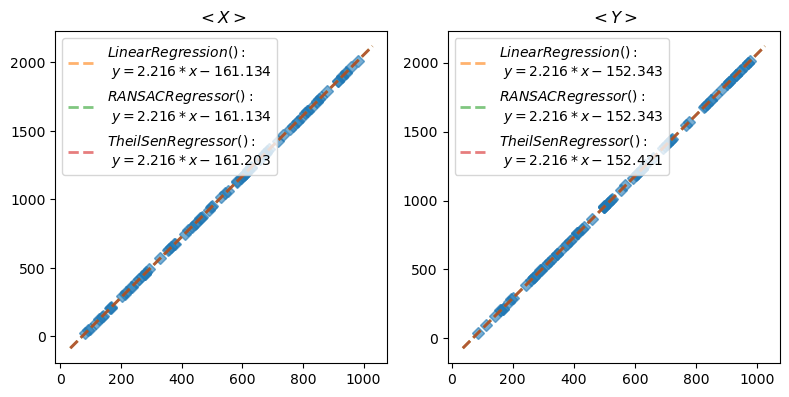

In [4]:
from sklearn import linear_model

%matplotlib inline
frame = 0

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

for ax,dd in zip(axs, dims):
    X = plushalf_TM["POSITION_"+dd.upper()][plushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = plushalf_df[dd][plushalf_df["frame"]==51+frame].iloc[:]

    if dd=="y":
        y = (2048 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

plt.tight_layout()

### Validate shift and rescale

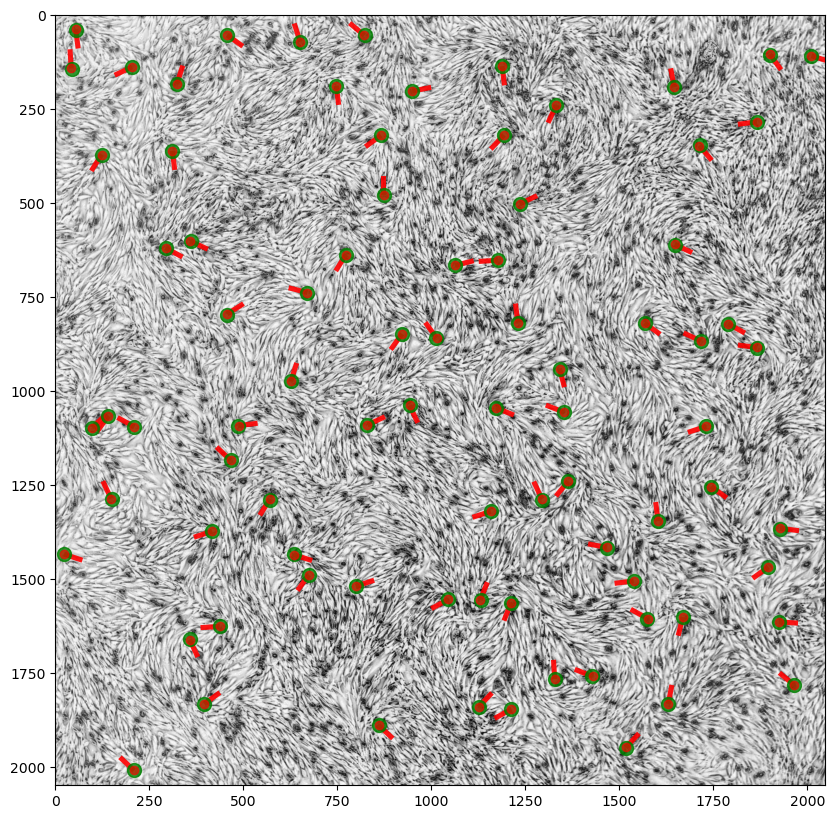

In [5]:
%matplotlib inline
SLOPEx = 2.2160372967706556
INTERCEPTx = -161.02498860090532
SLOPEy = 2.2160372967706556
INTERCEPTy = -152.4206270246462
frame = 0

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*s14*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[50:200:1]
im1 = image_list[0]

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusTM_spots.csv', skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==51+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

### Apply angle information data to TrackMate DataFrame

In [6]:
%matplotlib qt
SLOPEx = 2.2160372967706556
INTERCEPTx = -161.02498860090532
SLOPEy = 2.2160372967706556
INTERCEPTy = -152.4206270246462

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusTM_spots.csv', skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/PlusHalf1.csv')
minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusTM_spots.csv', skiprows=[1,2,3])
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_" + '/MinusHalf1.csv')

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

In [7]:
# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


[[ 291.  612.]
 [1062.  662.]
 [1184.  654.]] 
 [[ 291.04661994  611.52188524]
 [1062.22759922  662.49074307]
 [1184.10965054  653.62659388]] 
 [[ 291.  612.]
 [1062.  662.]
 [1184.  654.]]
--------------
[[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]] 
 [[1625.1010726  1553.33773637]
 [1556.4039164  1555.55377366]
 [1102.11627056 1613.17074338]] 
 [[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]]
--------------


In [ ]:
# replace and add angles
plushalf_TM[['x_img1','y_img1','ang1','charge']] =  plushalf_df[['x', 'y', 'ang1', 'charge']].iloc[idx[:]].values

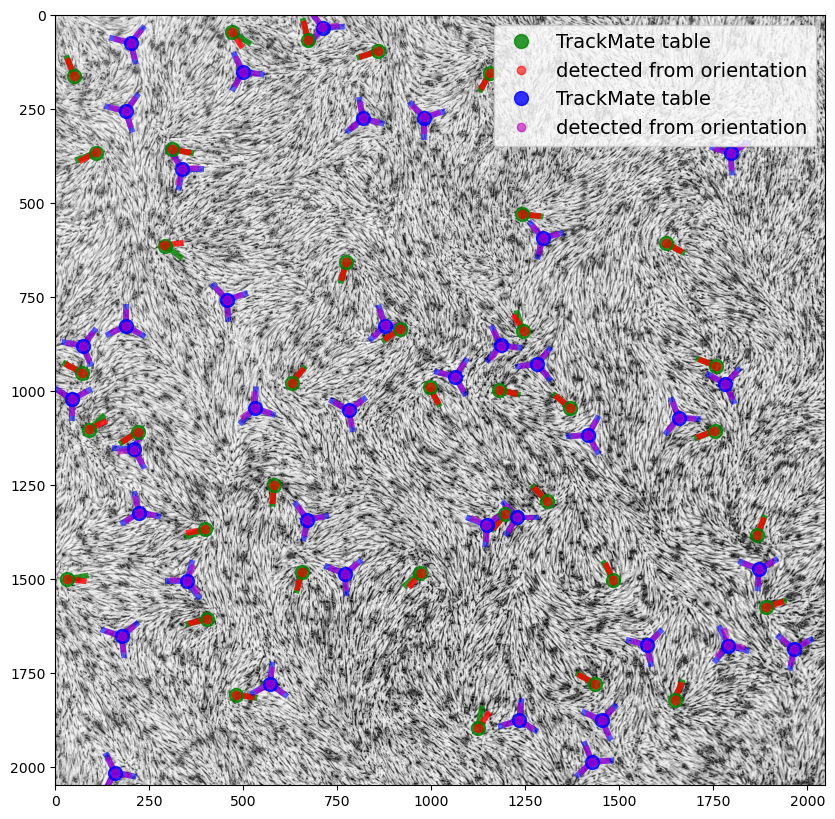

In [9]:
# test replaced values
%matplotlib inline
frame = 50

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*s14*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[50:200:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==51+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==51+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"], m_df["y"], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [ ]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\PlusAndMinusTM.csv")

# Start Here Find Pairs

In [3]:
plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\PlusAndMinusTM.csv")
plus_minus_df.head()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,charge,ang2,ang3
0,0,ID398982,398982,75.0,81.421524,980.0,944.0,0.0,0.0,0,...,0.973672,1.625018,2010.691562,108.481419,2012.0,108.0,0.188496,0.5,NaN,NaN
1,1,ID398983,398983,NaN,73.580887,930.0,946.0,0.0,0.0,0,...,0.976583,1.294861,1899.889697,104.049344,1900.0,103.0,0.942478,0.5,NaN,NaN
2,2,ID398980,398980,32.0,81.421516,165.0,931.0,0.0,0.0,0,...,0.973672,1.625018,204.621165,137.289904,204.0,137.0,2.701770,0.5,NaN,NaN
3,3,ID398981,398981,43.0,81.421524,609.0,932.0,0.0,0.0,0,...,0.973672,1.625018,1188.541725,135.073866,1188.0,135.0,1.445133,0.5,NaN,NaN
4,4,ID398978,398978,34.0,81.421524,218.0,911.0,0.0,0.0,0,...,0.973672,1.625018,322.071142,181.610650,323.0,182.0,-1.256637,0.5,NaN,NaN


In [4]:
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)   


pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a piar (50)
    dist_tresh = dist<50
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values, 
        plus_xy["TRACK_ID"][dist_tresh].values
        ]) 

pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T).dropna().drop_duplicates()    

## Pair Trajectories

In [69]:
mp_angle.median()

AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [136]:
%matplotlib qt
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
pair_stat = []
for (num,m), n in zip(enumerate(pairs_df[0]), pairs_df[1]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (10 frames)
    if m_idx.sum()>10 and p_idx.sum()>10:
        xm, ym = plus_minus_df["x_img1"][m_idx].values, plus_minus_df["y_img1"][m_idx].values
        xp, yp = plus_minus_df["x_img1"][p_idx].values, plus_minus_df["y_img1"][p_idx].values
        thm = np.array((
            plus_minus_df["ang1"][m_idx].values, 
            plus_minus_df["ang2"][m_idx].values,
            plus_minus_df["ang3"][m_idx].values
        ))
        thp = plus_minus_df["ang1"][p_idx].values
        thp[thp<0] = thp[thp<0] + 2*np.pi 

        try:
            mp_distance.append(((xm-xp)**2 + (ym-yp)**2)**.5)
            # angle btw defect centers
            mp_angle = np.arctan2(ym-yp, xm-xp) 
            # mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi 
            # m_ang = mp_angle - np.min(plus_minus_df["ang1"][p_idx],plus_minus_df["ang2"][p_idx],plus_minus_df["ang3"][p_idx])
            # p_ang = mp_angle - plus_minus_df["ang1"][p_idx]
            # pair_stat.append([mp_distance, m_ang, p_ang])
            # ax.quiver(xp, yp, np.cos(mp_angle), np.sin(mp_angle), alpha=.1)

            diff_thm = (thm - thp).T
            diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
            thm_min = np.min(np.abs(diff_thm), axis=1) + thp
            thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
            pair_stat.append([thp-np.median(mp_angle), thm-np.median(mp_angle)])

            for i in range(3):
                ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

            ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
            ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

            ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
            ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

            ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
            ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
            # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
            ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-np.median(mp_angle))*180/np.pi)//1) , fontsize=20)
            ax.text(xm[-1], ym[-1], "%s" %str((thm_min[-1]*180/np.pi)//1) , fontsize=20)

        except:
            count +=1
            print(len(xm), len(xp))
            pass

print(count)        
        

52 51
34 35
65 67
149 12
90 33
34 48
17 15
49 47
17 16
35 33
56 43
14 55
31 55
65 51
64 43
90 92
93 91
47 17
127 129
134 133
20


In [119]:
np.fmod(angs[1][0], 2/3*np.pi)*180/np.pi

array([-21.49268063, -17.89268063, -21.49268063, -15.49268063,
        -9.49268063, -17.89268063, -19.09268063,  -5.89268063,
       -17.89268063, -17.89268063, -17.89268063,  -5.89268063,
       -17.89268063, -14.29268063, -14.29268063, -17.89268063,
       -15.49268063,  -8.29268063, -11.89268063,  -5.89268063,
        -5.89268063,  -5.89268063, -25.09268063,  -5.89268063,
        -5.89268063,  -9.49268063, -25.09268063,  -5.89268063,
       -28.69268063])

(-10.0, 130.0)

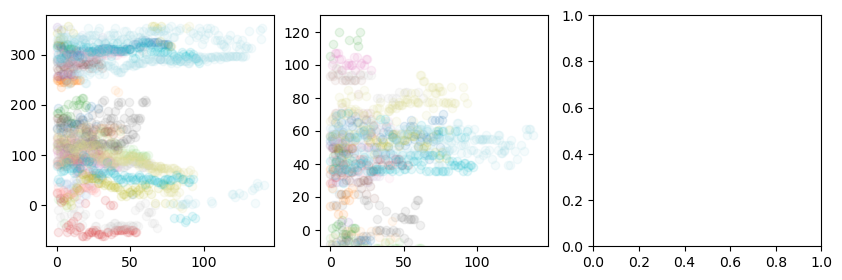

In [160]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(10,3))
colors = plt.cm.tab20(np.linspace(0, 1, num=len(pair_stat)))
plt.set_cmap('tab20')
pangles = []
mangles = []
for num, angs in enumerate(pair_stat):
    # print(angs[0],angs[1])
    # ax[0].plot(np.arange(len(angs[0])), np.fmod(angs[0], 2*np.pi)*180/np.pi, "o", alpha=.1)
    # ax[1].plot(np.arange(len(angs[1])), np.fmod(angs[1], 2*np.pi)*180/np.pi, "o", alpha=.05)
    ax[0].plot(np.arange(len(angs[0])), np.fmod(angs[0], 2*np.pi)*180/np.pi, "o", color=colors[num], alpha=.1)
    ax[1].plot(np.arange(len(angs[1][0])), np.fmod(angs[1][0], 2/3*np.pi)*180/np.pi, "o", color=colors[num], alpha=.1)
    # ax[2].plot(
    #     np.arange(len(angs[0])), 
    #     (np.fmod(angs[0], 2*np.pi) - np.fmod(angs[1], 2/3*np.pi))*180/np.pi, 
    #     "o", color=colors[num], alpha=.1)
    pangles.append(angs[0])
    mangles.append(np.concatenate(angs[1]))
    # if num>10:
    #     break

# ax[0].set_ylim([-10,370])
ax[1].set_ylim([-10,130])

In [180]:
%matplotlib qt
n_numbers = 100
bins_number = 60  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2.01 * np.pi, bins_number+1)
pangle = np.concatenate(pangles) #2*np.pi * np.ones((1,100)).ravel() #
mangle = np.concatenate(mangles)+3*2/3*np.pi#2*np.pi * np.ones((1,100)).ravel() #
pangle = np.fmod(pangle, 2*np.pi)
mangle = np.fmod(mangle, 2*np.pi)
pn, _, _ = plt.hist(pangle, bins, density=True)
mn, _, _ = plt.hist(mangle, bins,  density=True)

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
ax.bar(bins[:bins_number], pn, width=width, bottom=0.0, alpha=.5)
ax.bar(bins[:bins_number], mn, width=width, bottom=0.0, alpha=.5)


<BarContainer object of 60 artists>

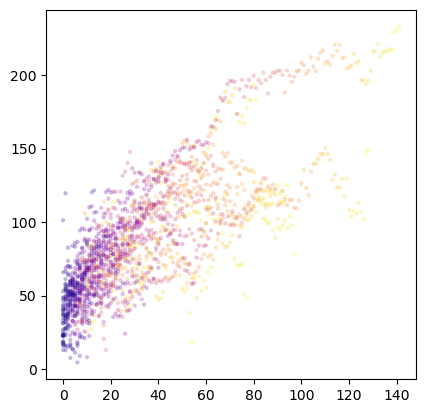

In [9]:
mp_distance_mat = np.zeros([len(mp_distance), len(max(mp_distance, key = lambda x: len(x)))])
mp_distance_mat[:] = np.nan
for i, dist in enumerate(mp_distance):
    # print(i, j)
    plt.scatter(np.arange(len(dist)), np.flip(dist), c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")
    mp_distance_mat[i,0:len(dist)] = np.flip(dist)
    
plt.gca().set_box_aspect(1)  

Text(0.5, 1.0, '$Distance ~Evolution ~Between ~Defect ~Pair$')

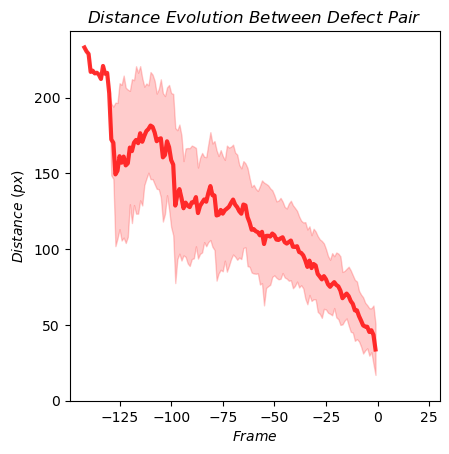

In [10]:
%matplotlib inline
for i in range(mp_distance_mat.shape[0]):
    y = mp_distance_mat[i,:][~np.isnan(mp_distance_mat[i,:])]
    # plt.scatter(np.arange(len(y)), y, c=np.arange(len(y)), s=3, alpha=.2, cmap="plasma")


mean, stdiv = np.flip(np.nanmean(mp_distance_mat, axis=0)), np.flip(np.nanstd(mp_distance_mat, axis=0))
max_frame = mp_distance_mat.shape[1]

plt.plot(np.arange(len(mean))-max_frame, mean, "r-", alpha=.8, linewidth=3)
plt.fill_between(np.arange(len(mean))-max_frame, mean-stdiv, mean+stdiv, color="red", alpha=.2)
plt.ylim([0,None])
plt.xlim([None,30])
plt.gca().set_box_aspect(1)  
plt.xlabel('$Frame$')
plt.ylabel('$Distance ~(px)$') #plt.ylabel('$Distance ~(\mu m)$')
plt.title('$Distance ~Evolution ~Between ~Defect ~Pair$')

In [ ]:
plt.plot(xp, yp,"ro", alpha=.1)
plt.plot(xm, ym,"bo", alpha=.1)
plt.gca().set_aspect(1)